<a href="https://colab.research.google.com/github/jhyeon-kim/ai_study/blob/main/%EC%9D%8C%EC%95%85_%EA%B0%90%EC%A0%95_%EB%B6%84%EB%A5%98_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchaudio pandas

In [ ]:
from google.colab import drive

# Google Drive ÎßàÏö¥Ìä∏
drive.mount('/content/drive')

csv_file_path = '/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/MER_audio_taffc_dataset/songs_moods_labeled.csv'

Mounted at /content/drive


In [21]:
import pandas as pd
import torchaudio
import os
from sklearn.model_selection import train_test_split

# Ïò§ÎîîÏò§ ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï Ìï®Ïàò
def get_audio_path(song, quadrant):
    return f'/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/MER_audio_taffc_dataset/{quadrant}/{song}.mp3'


# CSV ÌååÏùº Î°úÎìú
data = pd.read_csv(csv_file_path)

# Ïò§ÎîîÏò§ Í≤ΩÎ°ú Ïó¥ Ï∂îÍ∞Ä
data['audio_path'] = data.apply(lambda row: get_audio_path(row['Song'], row['Quadrant']), axis=1)

# # Train/Validation Split
# train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'])

# # Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ Í≤∞Í≥º ÌôïÏù∏
# print(f"Train data length: {len(train_data)}")
# print(f"Validation data length: {len(val_data)}")


## 2. MelSpectrogram Ï†ÑÏ≤òÎ¶¨ Î∞è Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ

Ïò§ÎîîÏò§ ÌååÏùºÏùÑ Î∂àÎü¨ÏôÄÏÑú CNNÏù¥ Ï≤òÎ¶¨Ìï† Ïàò ÏûàÎèÑÎ°ù Ïä§ÌéôÌä∏Î°úÍ∑∏Îû®ÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.



In [22]:
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch

import random

class AudioSpectrogramDataset(Dataset):
    def __init__(self, dataframe, target_sample_rate=16000, segment_length=80000):  # 5Ï¥à = 80000 ÏÉòÌîå
        self.data = dataframe
        self.labels = dataframe['label'].values
        self.audio_paths = dataframe['audio_path'].values
        self.mel_spectrogram = transforms.MelSpectrogram(sample_rate=target_sample_rate, n_mels=64)
        self.segment_length = segment_length  # Í≥†Ï†ïÎêú Í∏∏Ïù¥ 5Ï¥à
        self.segments = []
        self._prepare_segments()

    def _prepare_segments(self):
        # Í∞Å ÌååÏùºÏùÑ 5Ï¥à Îã®ÏúÑÎ°ú ÎÇòÎàÑÍ≥† ÏÑ∏Í∑∏Î®ºÌä∏ Î¶¨Ïä§Ìä∏Î•º ÎßåÎì†Îã§
        for idx, audio_path in enumerate(self.audio_paths):
            waveform, sample_rate = torchaudio.load(audio_path)
            label = self.labels[idx]
            num_segments = waveform.shape[1] // self.segment_length

            for segment_idx in range(num_segments):
                start = segment_idx * self.segment_length
                end = start + self.segment_length
                segment = waveform[:, start:end]

                # Ïä§ÌÖåÎ†àÏò§ Îç∞Ïù¥ÌÑ∞Î•º Î™®ÎÖ∏Î°ú Î≥ÄÌôò
                if segment.shape[0] > 1:
                    segment = segment.mean(dim=0, keepdim=True)

                # ÏÑ∏Í∑∏Î®ºÌä∏ÏôÄ Î†àÏù¥Î∏îÏùÑ Ï†ÄÏû•
                self.segments.append((segment, label))

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        segment, label = self.segments[idx]
        # MelSpectrogram Î≥ÄÌôò
        spec = self.mel_spectrogram(segment)
        return spec, label

# Audio Îç∞Ïù¥ÌÑ∞ ÏÑ∏Í∑∏Î®ºÌä∏ Ï§ÄÎπÑ
dataset = AudioSpectrogramDataset(data)

# ÏÑ∏Í∑∏Î®ºÌä∏ Îç∞Ïù¥ÌÑ∞Î•º ÏÑûÍ∏∞
random.shuffle(dataset.segments)

# Train/Validation Split (ÏÑ∏Í∑∏Î®ºÌä∏ Í∏∞Ï§ÄÏúºÎ°ú Î∂ÑÎ¶¨)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


# class AudioSpectrogramDataset(Dataset):
#     def __init__(self, dataframe, target_sample_rate=16000, max_length=160000):  # 10Ï¥à Í≥†Ï†ï Í∏∏Ïù¥
#         self.data = dataframe
#         self.labels = dataframe['label'].values
#         self.audio_paths = dataframe['audio_path'].values
#         self.mel_spectrogram = transforms.MelSpectrogram(sample_rate=target_sample_rate, n_mels=64)
#         self.max_length = max_length  # Í≥†Ï†ïÎêú Í∏∏Ïù¥

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         audio_path = self.audio_paths[idx]
#         label = self.labels[idx]

#         # Ïò§ÎîîÏò§ ÌååÏùº Î°úÎìú
#         waveform, sample_rate = torchaudio.load(audio_path)

#         # ÏÉòÌîåÎßÅ ÏÜçÎèÑ ÌÜµÏùº (16000HzÎ°ú Î¶¨ÏÉòÌîåÎßÅ)
#         if sample_rate != 16000:
#             waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

#         # Ïä§ÌÖåÎ†àÏò§ Îç∞Ïù¥ÌÑ∞Î•º Î™®ÎÖ∏Î°ú Î≥ÄÌôò (Ï±ÑÎÑêÏùÑ ÌèâÍ∑†ÌïòÏó¨ Î™®ÎÖ∏Î°ú ÎßåÎì§Í∏∞)
#         if waveform.shape[0] > 1:
#             waveform = waveform.mean(dim=0, keepdim=True)

#         # Í≥†Ï†ïÎêú Í∏∏Ïù¥Î°ú ÏûòÎùºÎÇ¥Í±∞ÎÇò Ìå®Îî© Ï†ÅÏö©
#         if waveform.shape[1] > self.max_length:
#             waveform = waveform[:, :self.max_length]  # ÏûêÎ•¥Í∏∞
#         else:
#             pad_size = self.max_length - waveform.shape[1]
#             waveform = F.pad(waveform, (0, pad_size), "constant", 0)  # Ìå®Îî©

#         # MelSpectrogram Î≥ÄÌôò
#         spec = self.mel_spectrogram(waveform)

#         # Ïä§ÌéôÌä∏Î°úÍ∑∏Îû® Ï∞®Ïõê Ï°∞Ï†ï (1, n_mels, time)
#         # spec = spec.unsqueeze(0)

#         return spec, label

AudioSpectrogramDatasetÏùÄ Í∞Å Ïò§ÎîîÏò§ ÌååÏùºÏùÑ Î∂àÎü¨ÏôÄÏÑú MelSpectrogramÏúºÎ°ú Î≥ÄÌôòÌïú ÌõÑ, CNNÏù¥ ÌïôÏäµÌï† Ïàò ÏûàÎäî ÌòïÏãùÏúºÎ°ú Î∞òÌôòÌï©ÎãàÎã§.



In [23]:
import torch

def pad_spectrogram(spec, max_length):
    # spec: [1, n_mels, time]
    pad_size = max_length - spec.shape[-1]
    return torch.nn.functional.pad(spec, (0, pad_size), "constant", 0)  # Ïò§Î•∏Ï™ΩÏúºÎ°ú Ìå®Îî©

def collate_fn(batch):
    specs, labels = zip(*batch)

    # Í∞Å Î∞∞ÏπòÏùò Í∞ÄÏû• Í∏¥ Ïä§ÌéôÌä∏Î°úÍ∑∏Îû® Í∏∏Ïù¥ Ï∞æÍ∏∞
    max_length = max([spec.shape[-1] for spec in specs])

    # Ìå®Îî© Ï†ÅÏö©ÌïòÏó¨ Î™®Îì† Ïä§ÌéôÌä∏Î°úÍ∑∏Îû®Ïùò Í∏∏Ïù¥ ÎßûÏ∂îÍ∏∞
    padded_specs = [pad_spectrogram(spec, max_length) for spec in specs]

    # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
    padded_specs = torch.stack(padded_specs)
    labels = torch.tensor(labels)

    return padded_specs, labels


In [24]:
# DataLoader ÏÑ§Ï†ï
# train_loader = DataLoader(AudioSpectrogramDataset(train_data), batch_size=16, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(AudioSpectrogramDataset(val_data), batch_size=16, shuffle=False, collate_fn=collate_fn)



# DataLoader ÏÑ§Ï†ï
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [25]:
from collections import Counter

# Train/Validation Dataset ÌÅ¨Í∏∞ Ï∂úÎ†•
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Train Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î Î∂ÑÌè¨ Ï∂úÎ†•
train_labels = [label for _, label in train_dataset]
train_label_count = Counter(train_labels)
print(f"Train label distribution: {train_label_count}")

# Validation Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î Î∂ÑÌè¨ Ï∂úÎ†•
val_labels = [label for _, label in val_dataset]
val_label_count = Counter(val_labels)
print(f"Validation label distribution: {val_label_count}")


Train dataset size: 7810
Validation dataset size: 1953
Train label distribution: Counter({2: 3185, 0: 2249, 1: 927, 3: 725, 4: 724})
Validation label distribution: Counter({2: 799, 0: 573, 1: 229, 4: 188, 3: 164})


In [26]:
import torch.nn as nn
import torch.nn.functional as F
class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes=5):  # Í∞êÏ†ï Î∂ÑÎ•ò ÌÅ¥ÎûòÏä§ Ïàò
        super(CNNEmotionClassifier, self).__init__()

        # CNN Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 50, 256)  # 128 * 8 * 50 = 51200
        self.fc2 = nn.Linear(256, num_classes)  # Í∞êÏ†ï Î∂ÑÎ•ò Î†àÏù¥Î∏î Ïàò

    def forward(self, x):
        # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: [batch_size, 1, 64, time]
        x = self.pool(F.relu(self.conv1(x)))  # (N, 32, 64, time/2)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 64, 32, time/4)
        x = self.pool(F.relu(self.conv3(x)))  # (N, 128, 16, time/8)

        # CNN Ï∂úÎ†• ÌõÑ ÌÅ¨Í∏∞ Ï∂úÎ†•
        # print(f"After conv3: {x.shape}")

        # Flatten: Conv Î†àÏù¥Ïñ¥Ïùò Ï∂úÎ†•ÏùÑ 1DÎ°ú Î≥ÄÌôò
        x = x.view(x.size(0), -1)  # Flatten (N, 128 * 8 * 50 = 51200)
        # print(f"After flatten: {x.shape}")

        # Fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
import torch.optim as optim

# Î™®Îç∏ Ï¥àÍ∏∞Ìôî
model = CNNEmotionClassifier(num_classes=5)  # 5Í∞ú Í∞êÏ†ï Î≤îÏ£º
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [28]:
# GPUÍ∞Ä ÏÇ¨Ïö© Í∞ÄÎä•ÌïòÎ©¥ GPUÎ°ú Î™®Îç∏ Ïù¥Îèô
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

    # Í≤ÄÏ¶ù Îã®Í≥Ñ
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy}')


Epoch 1, Loss: 1.8414517695918404
Validation Loss: 1.2914679743410127, Accuracy: 47.20942140296979
Epoch 2, Loss: 1.177558949632391
Validation Loss: 1.2935698754419156, Accuracy: 49.56477214541731
Epoch 3, Loss: 0.9550406514135606
Validation Loss: 1.3258322336809423, Accuracy: 48.18228366615463
Epoch 4, Loss: 0.7409543528512943
Validation Loss: 1.4832948344509775, Accuracy: 46.49257552483359
Epoch 5, Loss: 0.5641409681047216
Validation Loss: 1.8008904985296048, Accuracy: 48.18228366615463
Epoch 6, Loss: 0.4284386960732425
Validation Loss: 2.005866794566798, Accuracy: 45.41730670762929
Epoch 7, Loss: 0.3409318495808447
Validation Loss: 2.2034085674014516, Accuracy: 42.959549411162314
Epoch 8, Loss: 0.2598536658902597
Validation Loss: 2.6173818290718205, Accuracy: 45.46850998463902
Epoch 9, Loss: 0.21194169693102713
Validation Loss: 2.819489456925208, Accuracy: 43.061955965181774
Epoch 10, Loss: 0.16997566734510142
Validation Loss: 2.954807714104834, Accuracy: 45.878136200716845


## dropout Ï†ÅÏö©ÏãúÎèÑ

In [29]:
import torch.nn as nn
import torch.nn.functional as F
class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes=5):  # Í∞êÏ†ï Î∂ÑÎ•ò ÌÅ¥ÎûòÏä§ Ïàò
        super(CNNEmotionClassifier, self).__init__()

        # CNN Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 50, 256)  # 128 * 8 * 50 = 51200
        self.fc2 = nn.Linear(256, num_classes)  # Í∞êÏ†ï Î∂ÑÎ•ò Î†àÏù¥Î∏î Ïàò

    def forward(self, x):
        # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: [batch_size, 1, 64, time]
        x = self.pool(F.relu(self.conv1(x)))  # (N, 32, 64, time/2)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 64, 32, time/4)
        x = self.pool(F.relu(self.conv3(x)))  # (N, 128, 16, time/8)

        # CNN Ï∂úÎ†• ÌõÑ ÌÅ¨Í∏∞ Ï∂úÎ†•
        # print(f"After conv3: {x.shape}")

        # Flatten: Conv Î†àÏù¥Ïñ¥Ïùò Ï∂úÎ†•ÏùÑ 1DÎ°ú Î≥ÄÌôò
        x = x.view(x.size(0), -1)  # Flatten (N, 128 * 8 * 50 = 51200)
        # print(f"After flatten: {x.shape}")

        # Fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [30]:
import torch.optim as optim

# Î™®Îç∏ Ï¥àÍ∏∞Ìôî
model = CNNEmotionClassifier(num_classes=5)  # 5Í∞ú Í∞êÏ†ï Î≤îÏ£º
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [31]:
import torch
import os
# GPUÍ∞Ä ÏÇ¨Ïö© Í∞ÄÎä•ÌïòÎ©¥ GPUÎ°ú Î™®Îç∏ Ïù¥Îèô
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Î™®Îç∏ÏùÑ Ï†ÄÏû•Ìï† ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï
model_save_path = "/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/sentiment_classification_cnn_model.pth"  # ÏõêÌïòÎäî Í≤ΩÎ°úÎ°ú ÏàòÏ†ï

# Ï¥àÍ∏∞Ìôî
best_val_accuracy = 0.0  # ÏµúÍ≥† Í≤ÄÏ¶ù Ï†ïÌôïÎèÑÎ•º Ï∂îÏ†Å

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

    # Í≤ÄÏ¶ù Îã®Í≥Ñ
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {val_accuracy}')

    # ÌòÑÏû¨ ÏóêÌè≠ÏóêÏÑúÏùò validation accuracyÍ∞Ä ÏµúÍ≥†Ïùº Í≤ΩÏö∞ Î™®Îç∏ Ï†ÄÏû•
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f'New best accuracy: {best_val_accuracy}. Saving model...')
        torch.save(model.state_dict(), model_save_path)

print(f"Training completed. Best validation accuracy: {best_val_accuracy}")


Epoch 1, Loss: 1.8280035229304572
Validation Loss: 1.3277188447432788, Accuracy: 46.64618535586278
New best accuracy: 46.64618535586278. Saving model...
Epoch 2, Loss: 1.1920707158150117
Validation Loss: 1.3125855394495212, Accuracy: 47.97747055811572
New best accuracy: 47.97747055811572. Saving model...
Epoch 3, Loss: 0.9962665126611362
Validation Loss: 1.3661167466543553, Accuracy: 48.131080389144905
New best accuracy: 48.131080389144905. Saving model...
Epoch 4, Loss: 0.8027673959122601
Validation Loss: 1.5208506642318353, Accuracy: 47.77265745007681
Epoch 5, Loss: 0.598117796068055
Validation Loss: 1.6698586998916254, Accuracy: 46.95340501792115
Epoch 6, Loss: 0.4489118230123461
Validation Loss: 1.9378350558804303, Accuracy: 46.74859190988223
Epoch 7, Loss: 0.37548643734557496
Validation Loss: 2.2161746221344645, Accuracy: 47.15821812596006
Epoch 8, Loss: 0.26088656711150227
Validation Loss: 2.5798964673668388, Accuracy: 48.89912954429084
New best accuracy: 48.89912954429084. Savin

In [32]:
!pip install huggingface_hub

In [34]:
from huggingface_hub import notebook_login

notebook_login()


In [35]:
from huggingface_hub import HfApi, HfFolder, upload_file

# Î™®Îç∏ ÏóÖÎ°úÎìú Í≤ΩÎ°ú ÏÑ§Ï†ï
repository_id = "jeonghyeon97/music_emontion_classifier_1"

# Hugging Face HubÏóê ÏÉà Ï†ÄÏû•ÏÜå ÏÉùÏÑ±
api = HfApi()
api.create_repo(repo_id=repository_id)

# Î™®Îç∏ ÏóÖÎ°úÎìú
model_path = model_save_path  # Ï†ÄÏû•Îêú Î™®Îç∏ Í≤ΩÎ°ú
upload_file(
    path_or_fileobj=model_path,
    path_in_repo="pytorch_model.bin",  # Ï†ÄÏû•ÏÜåÏóê Ï†ÄÏû•Îê† ÌååÏùºÎ™Ö
    repo_id=repository_id
)

# Î™®Îç∏ ÏÑ§Î™ÖÏùÑ Ï∂îÍ∞ÄÌïòÍ∏∞ ÏúÑÌï¥ README ÌååÏùº ÏóÖÎ°úÎìú
model_card_content = """
# CNN Emotion Classifier

This model was trained on music emotion classification using a CNN architecture.
"""
with open("README.md", "w") as f:
    f.write(model_card_content)

upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",  # README ÌååÏùº ÏóÖÎ°úÎìú
    repo_id=repository_id
)

print(f"Model uploaded to: https://huggingface.co/{repository_id}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentiment_classification_cnn_model.pth:   0%|          | 0.00/52.8M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:3757: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Model uploaded to: https://huggingface.co/jeonghyeon97/music_emontion_classifier_1


## ÏÉàÎ°úÏö¥ DS Î°ú ÌïôÏäµ

In [41]:
set1_csv_path = '/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/set1_labeled.csv'

set1_data = pd.read_csv(set1_csv_path)


# Ïò§ÎîîÏò§ ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï Ìï®Ïàò
def get_new_audio_path_osf(set, number):
    song_num_str = str(number).zfill(3)
    return f'/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/{set}/{song_num_str}.mp3'

set1_data['audio_path'] = set1_data.apply(lambda row: get_new_audio_path_osf("Set1", row['Nro']), axis=1)



In [42]:
# Dataset Ï§ÄÎπÑ (5Ï¥àÏî© Ï°∞Í∞ÅÎÇ¥Í∏∞)
dataset = AudioSpectrogramDataset(set1_data)

# ÏÑ∏Í∑∏Î®ºÌä∏Î•º ÏÑûÍ∏∞
random.shuffle(dataset.segments)

In [43]:
# Train/Validation Split (ÏÑûÏù∏ ÏÑ∏Í∑∏Î®ºÌä∏Î°úÎ∂ÄÌÑ∞ Î∂ÑÎ¶¨)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader ÏÑ§Ï†ï
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [44]:
from collections import Counter

# Train/Validation Dataset ÌÅ¨Í∏∞ Ï∂úÎ†•
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Train Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î Î∂ÑÌè¨ Ï∂úÎ†•
train_labels = [label for _, label in train_dataset]
train_label_count = Counter(train_labels)
print(f"Train label distribution: {train_label_count}")

# Validation Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î Î∂ÑÌè¨ Ï∂úÎ†•
val_labels = [label for _, label in val_dataset]
val_label_count = Counter(val_labels)
print(f"Validation label distribution: {val_label_count}")


Train dataset size: 1110
Validation dataset size: 278
Train label distribution: Counter({4: 239, 2: 222, 3: 219, 1: 218, 0: 212})
Validation label distribution: Counter({3: 64, 0: 56, 2: 55, 1: 53, 4: 50})


In [45]:
# Î™®Îç∏ÏùÑ Î∂àÎü¨Ïò§Í≥† ÌïôÏäµÏùÑ Ïù¥Ïñ¥ÏÑú ÏßÑÌñâ

model_save_path = "/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/sentiment_classification_cnn_model.pth"  # ÏõêÌïòÎäî Í≤ΩÎ°úÎ°ú ÏàòÏ†ï


model = CNNEmotionClassifier(num_classes=5)
model.load_state_dict(torch.load(model_save_path))
model.to(device)

<ipython-input-45-24d67f3830f5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


CNNEmotionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=51200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

In [46]:
# Optimizer Î∞è Loss ÏÑ§Ï†ï
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # ÌïôÏäµÎ•†ÏùÑ Îã§Ïãú ÏÑ§Ï†ï Í∞ÄÎä•

# Ïù¥Ïñ¥ÏÑú ÌïôÏäµ
num_epochs = 10
best_val_accuracy = 45.0  # ÏµúÍ≥† Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ Ï¥àÍ∏∞Ìôî

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

    # Í≤ÄÏ¶ù Îã®Í≥Ñ
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {val_accuracy}')

    # ÏµúÍ≥† Í≤ÄÏ¶ù Ï†ïÌôïÎèÑÎ•º Í∞±Ïã†ÌïòÎ©¥ Î™®Îç∏ Ï†ÄÏû•
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f'New best accuracy: {best_val_accuracy}. Saving model...')
        torch.save(model.state_dict(), model_save_path)

print(f"Training completed. Best validation accuracy: {best_val_accuracy}")

Epoch 1, Loss: 1.5631300534520831
Validation Loss: 1.2120800250106387, Accuracy: 44.24460431654676
Epoch 2, Loss: 1.0471421556813376
Validation Loss: 1.141543020804723, Accuracy: 51.07913669064748
New best accuracy: 51.07913669064748. Saving model...
Epoch 3, Loss: 0.8225642821618488
Validation Loss: 1.1635628177060022, Accuracy: 50.719424460431654
Epoch 4, Loss: 0.6353204539843968
Validation Loss: 1.286088873942693, Accuracy: 48.92086330935252
Epoch 5, Loss: 0.5246457553335598
Validation Loss: 1.21509683628877, Accuracy: 57.55395683453237
New best accuracy: 57.55395683453237. Saving model...
Epoch 6, Loss: 0.44571563260895863
Validation Loss: 1.4295743372705247, Accuracy: 49.64028776978417
Epoch 7, Loss: 0.4223329351416656
Validation Loss: 1.3562135067250993, Accuracy: 53.23741007194245
Epoch 8, Loss: 0.3178858321160078
Validation Loss: 1.3785655332936182, Accuracy: 53.9568345323741
Epoch 9, Loss: 0.3338093817234039
Validation Loss: 1.673694199985928, Accuracy: 48.201438848920866
Epoc

In [47]:
from huggingface_hub import HfApi, HfFolder, upload_file

# Î™®Îç∏ ÏóÖÎ°úÎìú Í≤ΩÎ°ú ÏÑ§Ï†ï
repository_id = "jeonghyeon97/music_emontion_classifier_2"

# Hugging Face HubÏóê ÏÉà Ï†ÄÏû•ÏÜå ÏÉùÏÑ±
api = HfApi()
api.create_repo(repo_id=repository_id)

# Î™®Îç∏ ÏóÖÎ°úÎìú
model_path = model_save_path  # Ï†ÄÏû•Îêú Î™®Îç∏ Í≤ΩÎ°ú
upload_file(
    path_or_fileobj=model_path,
    path_in_repo="pytorch_model.bin",  # Ï†ÄÏû•ÏÜåÏóê Ï†ÄÏû•Îê† ÌååÏùºÎ™Ö
    repo_id=repository_id
)

# Î™®Îç∏ ÏÑ§Î™ÖÏùÑ Ï∂îÍ∞ÄÌïòÍ∏∞ ÏúÑÌï¥ README ÌååÏùº ÏóÖÎ°úÎìú
model_card_content = """
# CNN Emotion Classifier

This model was trained on music emotion classification using a CNN architecture.
(Additional Learning with OSF_IO dataset)
"""
with open("README.md", "w") as f:
    f.write(model_card_content)

upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",  # README ÌååÏùº ÏóÖÎ°úÎìú
    repo_id=repository_id
)

print(f"Model uploaded to: https://huggingface.co/{repository_id}")


sentiment_classification_cnn_model.pth:   0%|          | 0.00/52.8M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:3757: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Model uploaded to: https://huggingface.co/jeonghyeon97/music_emontion_classifier_2


In [50]:
import torch
import torch.nn.functional as F
import numpy as np

# Í∞ÑÎã®Ìïú ÏòàÏ∏° Ìï®Ïàò (Validation Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Î™á Í∞úÏùò ÏòàÏãúÎ•º Ï∂úÎ†•ÌïòÍ≥†, ÏòàÏ∏° ÌôïÎ•† Ìè¨Ìï®)
def evaluate_model_with_confidence(model, val_loader, num_examples=5):
    model.eval()  # ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ï†ÑÌôò (ÎìúÎ°≠ÏïÑÏõÉ, Î∞∞Ïπò Ï†ïÍ∑úÌôî ÎπÑÌôúÏÑ±Ìôî)
    examples_shown = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Î™®Îç∏Ïóê ÏûÖÎ†•ÏùÑ ÎÑ£Í≥† ÏòàÏ∏°
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)  # ÏÜåÌîÑÌä∏Îß•Ïä§ Ï†ÅÏö©ÌïòÏó¨ ÌôïÎ•†Î°ú Î≥ÄÌôò
            _, predicted = torch.max(outputs, 1)

            # Ïã§Ï†ú Î†àÏù¥Î∏îÍ≥º ÏòàÏ∏°Îêú Î†àÏù¥Î∏î, Í∞Å Î≤îÏ£ºÎ≥Ñ ÌôïÎ•† Ï∂úÎ†• (ÏµúÎåÄ num_examplesÎßå Ï∂úÎ†•)
            for i in range(len(labels)):
                actual_label = labels[i].item()
                predicted_label = predicted[i].item()
                class_probabilities = probabilities[i].cpu().numpy()  # GPU ÏÇ¨Ïö© Ïãú CPUÎ°ú Ïù¥Îèô
                class_probabilities = np.round(class_probabilities, 2)  # ÏÜåÏàòÏ†ê ÏïÑÎûò 2ÏûêÎ¶¨Î°ú Ï†úÌïú

                # ÏòàÏ∏° Í≤∞Í≥º Ï∂úÎ†•
                print(f"Actual: {actual_label}, Predicted: {predicted_label}")
                print(f"Probabilities: {class_probabilities}")
                print("-" * 50)  # Íµ¨Î∂ÑÏÑ†

                examples_shown += 1
                if examples_shown >= num_examples:
                    return

# Î™®Îç∏ ÌèâÍ∞Ä (5Í∞úÏùò ÏòàÏãú ÌôïÏù∏, Í∞Å Î≤îÏ£ºÎ≥Ñ ÌôïÎ•† Ìè¨Ìï®)
evaluate_model_with_confidence(model, val_loader, num_examples=5)


Actual: 1, Predicted: 1
Probabilities: [0. 1. 0. 0. 0.]
--------------------------------------------------
Actual: 2, Predicted: 2
Probabilities: [0.01 0.01 0.98 0.01 0.  ]
--------------------------------------------------
Actual: 1, Predicted: 1
Probabilities: [0.04 0.7  0.03 0.05 0.18]
--------------------------------------------------
Actual: 2, Predicted: 2
Probabilities: [0.08 0.07 0.85 0.   0.  ]
--------------------------------------------------
Actual: 0, Predicted: 0
Probabilities: [1. 0. 0. 0. 0.]
--------------------------------------------------


## Îã§Î•∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌèâÍ∞ÄÌï¥Î≥¥Í∏∞ (OSF Ïùò set2)

In [51]:
import torch
import torchaudio
from sklearn.model_selection import train_test_split

# ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ÏÖã Í≤ΩÎ°úÏôÄ CSV ÌååÏùº Í≤ΩÎ°ú
new_eval_csv_file_path = '/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/set2_labeled.csv'
new_eval_data = pd.read_csv(new_eval_csv_file_path)


# Ïò§ÎîîÏò§ ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï Ìï®Ïàò
def get_new_eval_audio_path(set, number):
    song_num_str = str(number).zfill(3)
    return f'/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/{set}/{song_num_str}.mp3'

new_eval_data['audio_path'] = new_eval_data.apply(lambda row: get_new_eval_audio_path("set2", row['Nro']), axis=1)


# Dataset ÏÑ§Ï†ï (Ïù¥Ï†ÑÍ≥º ÎèôÏùºÌïú Î∞©Ïãù)
eval_dataset = AudioSpectrogramDataset(new_eval_data)

# DataLoader ÏÑ§Ï†ï
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ï†ÑÌôò
model.eval()

# ÌèâÍ∞Ä Î©îÌä∏Î¶≠ Í≥ÑÏÇ∞ (Ïòà: Ï†ïÌôïÎèÑ)
correct = 0
total = 0

with torch.no_grad():
    for batch in eval_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Ï†ïÌôïÎèÑ Ï∂úÎ†•
accuracy = 100 * correct / total
print(f'Accuracy on new dataset: {accuracy}%')


Accuracy on new dataset: 37.188208616780045%


In [56]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification

# Í∞êÏ†ï Î≤îÏ£º Ï†ïÏùò (Í∞Å Î†àÏù¥Î∏îÏóê Ìï¥ÎãπÌïòÎäî Í∞êÏ†ï Ïù¥Î¶Ñ)
emotion_labels = ["üò° Angry", "üò± Fear", "üòÉ Happy", "üòä Tender", "üò¢ Sad"]

# Hugging FaceÏóêÏÑú Î™®Îç∏ÏùÑ Î∂àÎü¨ÏôÄ ÏòàÏ∏°ÌïòÎäî Ìï®Ïàò
def predict_emotion_from_audio(model, audio_file_path, target_sample_rate=16000, segment_length=80000):
    model.eval()  # ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï

    # Ïò§ÎîîÏò§ ÌååÏùº Î°úÎìú
    waveform, sample_rate = torchaudio.load(audio_file_path)

    # Î¶¨ÏÉòÌîåÎßÅ (ÌïÑÏöîÌïú Í≤ΩÏö∞)
    if sample_rate != target_sample_rate:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)(waveform)

    # Ïä§ÌÖåÎ†àÏò§ Îç∞Ïù¥ÌÑ∞Î•º Î™®ÎÖ∏Î°ú Î≥ÄÌôò
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # 5Ï¥à Î∂ÑÎüâÏù¥ ÏïÑÎãàÎ©¥ ÏûêÎ•¥Í±∞ÎÇò Ìå®Îî© (ÌïÑÏöîÏãú)
    if waveform.shape[1] > segment_length:
        waveform = waveform[:, :segment_length]
    else:
        pad_size = segment_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad_size))

    # Mel Spectrogram Î≥ÄÌôò
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=target_sample_rate, n_mels=64)
    spec = mel_spectrogram(waveform)

    # Ï∞®Ïõê ÎßûÏ∂îÍ∏∞ (batch dimension Ï∂îÍ∞Ä)
    spec = spec.unsqueeze(0)  # [1, 1, n_mels, time]

    # Î™®Îç∏Ïóê ÏûÖÎ†•ÌïòÍ≥† ÏòàÏ∏°
    with torch.no_grad():
        output = model(spec.to(device))
        probabilities = F.softmax(output, dim=1)  # ÌôïÎ•†Î°ú Î≥ÄÌôò
        _, predicted = torch.max(output, 1)  # Í∞ÄÏû• ÎÜíÏùÄ ÌôïÎ•†Ïùò Í∞êÏ†ï ÏÑ†ÌÉù

    # Í≤∞Í≥º Ï∂úÎ†•
    predicted_emotion = emotion_labels[predicted.item()]
    class_probabilities = probabilities.cpu().numpy()[0]

    print(f"Predicted Emotion: {predicted_emotion}")
    print("Probabilities for each emotion category:")
    for idx, label in enumerate(emotion_labels):
        print(f"{label}: {class_probabilities[idx]:.2f}")

    # ÎßâÎåÄ Í∑∏ÎûòÌîÑÎ°ú Í∞êÏ†ïÎ≥Ñ ÌôïÎ•† ÏãúÍ∞ÅÌôî
    display_emotion_probabilities(class_probabilities, emotion_labels)

# Í∞êÏ†ïÎ≥Ñ ÌôïÎ•†ÏùÑ ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò
def display_emotion_probabilities(probabilities, emotion_labels):
    plt.figure(figsize=(8, 5))
    plt.bar(emotion_labels, probabilities, color='skyblue')
    plt.ylim([0, 1])
    plt.title("Emotion Prediction Probabilities")
    plt.xlabel("Emotion")
    plt.ylabel("Probability")
    plt.show()

<ipython-input-73-e9a3d04385d5>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predicted Emotion: üòÉ Happy
Probabilities for each emotion category:
üò° Angry: 0.00
üò± Fear: 0.19
üòÉ Happy: 0.81
üòä Tender: 0.00
üò¢ Sad: 0.00


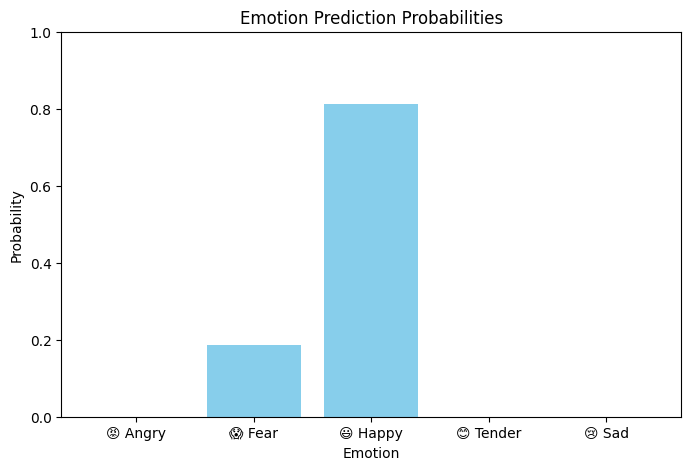

In [73]:
from huggingface_hub import hf_hub_download
import torch

# Hugging Face Ï†ÄÏû•ÏÜåÏóêÏÑú PyTorch Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
model_name = "jeonghyeon97/music_emontion_classifier_2"
filename = "pytorch_model.bin"  # ÏóÖÎ°úÎìúÌïú ÌååÏùº Ïù¥Î¶Ñ

# Hugging Face HubÏóêÏÑú Î™®Îç∏ Îã§Ïö¥Î°úÎìú
model_path = hf_hub_download(repo_id=model_name, filename=filename)

# Î™®Îç∏ Î°úÎìú
model = CNNEmotionClassifier(num_classes=5)
model.load_state_dict(torch.load(model_path))
model.to(device)


# ÏòàÏ∏° Ìï®Ïàò ÏÇ¨Ïö© ÏòàÏãú
base_path = "/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/"
# audio_file_path = base_path + "OSF_IO/Set1/002.mp3"
audio_file_path = base_path + "my_test/JingleBells.mp3"
predict_emotion_from_audio(model, audio_file_path)


##

In [72]:
import torch
import torchaudio
from sklearn.model_selection import train_test_split


# ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ÏÖã Í≤ΩÎ°úÏôÄ CSV ÌååÏùº Í≤ΩÎ°ú
new_eval_csv_file_path1 = '/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/set1_labeled.csv'
new_eval_data1 = pd.read_csv(new_eval_csv_file_path1)


# Ïò§ÎîîÏò§ ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï Ìï®Ïàò
def get_new_eval_audio_path(set, number):
    song_num_str = str(number).zfill(3)
    return f'/content/drive/MyDrive/sentiment_classification_projects_241014/music_sentiments_classification/OSF_IO/{set}/{song_num_str}.mp3'

new_eval_data1['audio_path'] = new_eval_data1.apply(lambda row: get_new_eval_audio_path("Set1", row['Nro']), axis=1)


# Dataset ÏÑ§Ï†ï (Ïù¥Ï†ÑÍ≥º ÎèôÏùºÌïú Î∞©Ïãù)
eval_dataset = AudioSpectrogramDataset(new_eval_data1)

# DataLoader ÏÑ§Ï†ï
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ï†ÑÌôò
model.eval()

# ÌèâÍ∞Ä Î©îÌä∏Î¶≠ Í≥ÑÏÇ∞ (Ïòà: Ï†ïÌôïÎèÑ)
correct = 0
total = 0

with torch.no_grad():
    for batch in eval_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Ï†ïÌôïÎèÑ Ï∂úÎ†•
accuracy = 100 * correct / total
print(f'Accuracy on new dataset: {accuracy}%')


Accuracy on new dataset: 81.12391930835734%
